In [1]:
'''
Title: Variational Autoencoder
This code has been written from the help of code in Keras code examples.
'''

import tensorflow as tf
import numpy as np
from tensorflow.keras import Model, layers
from tensorflow.keras.layers import Conv2D, Flatten, Dense, Reshape
import matplotlib.pyplot as plt

In [51]:
(x_train, y_train),(x_test,y_test) = tf.keras.datasets.mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

x_train.shape

(60000, 28, 28, 1)

In [13]:
class VAE(Model):
    class Sampling(layers.Layer):
        def call(self, inputs):
            z_mean, z_log_var = inputs
            epsilon = tf.keras.backend.random_normal(shape=tf.shape(z_mean))
            return z_mean + tf.exp(0.5* z_log_var) * epsilon
    
    def __init__(self, img_shape, latent_dim, summary = True, **kwargs):
        super(VAE, self).__init__(**kwargs)
        
        
        '''Defining encoder model'''
        inputs = tf.keras.Input(shape= img_shape)
        x = Flatten()(inputs)
        x = Dense(512, activation="relu")(x)
        mean = Dense(latent_dim, name="mean")(x)
        log_var = Dense(latent_dim, name="log_var")(x)
        
        #reparameterisation trick(sampling from a random distribution)
        sampled = self.Sampling()([mean, log_var])
        
        #create encoder model
        self.encoder = Model(inputs, [sampled,mean,log_var], name = "Encoder")
        
        
        '''Defining decoder model'''
        latent_input = tf.keras.Input(shape= (latent_dim))
        y = Dense(512, activation="relu")(latent_input)
        output = Dense(784, activation="relu")(y)
        output = Reshape(img_shape)(output)
        
        #create decoder model
        self.decoder = Model(latent_input, output, name = "Decoder")
        
        # create Variational Autoencoder
        encoded, mean, log_var = self.encoder(inputs)
        decoded = self.decoder(encoded)
        self.vae_model = Model(inputs, decoded, name = "VAE")
        
        
        #creating the 3 loss trackers
        self.total_loss_tracker = tf.keras.metrics.Mean(name="loss")
        self.reconstruction_loss_tracker = tf.keras.metrics.Mean(name="recon_loss")
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")
        
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

    
    @property
    def metrics(self):
        return [ self.total_loss_tracker, self.reconstruction_loss_tracker, self.kl_loss_tracker]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            encoded, mean, log_var = self.encoder(data)
            decoded = self.decoder(encoded)
            recon_loss = tf.reduce_sum(tf.keras.losses.binary_crossentropy(data, decoded), axis =(1, 2))
            recon_loss = tf.reduce_mean(recon_loss)
            kl_loss = -0.5 * (1 + log_var - tf.square(mean) - tf.exp(log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = recon_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(recon_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return { m.name : m.result() for m in self.metrics}

In [14]:
latent_dim = 2
img_shape = (28,28,1)

vae = VAE(img_shape, latent_dim)

vae.encoder.summary()
vae.decoder.summary()
vae.vae_model.summary()


Model: "Encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 784)          0           input_3[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 512)          401920      flatten_1[0][0]                  
__________________________________________________________________________________________________
mean (Dense)                    (None, 2)            1026        dense_3[0][0]                    
____________________________________________________________________________________________

In [15]:
# def loss_function(mean, variance):
#     def total_loss(y_true, y_pred):

#         reconstruction_loss = tf.keras.losses.mse(y_true, y_pred)
#         reconstruction_loss_batch = tf.reduce_mean(reconstruction_loss)*28*28

#         kl_loss = 1 + variance - tf.square(mean) - tf.exp(variance)
#         kl_loss_batch = tf.reduce_mean(kl_loss)*(-0.5)

#         return reconstruction_loss_batch + kl_loss_batch
    
#     return total_loss
    
# inputs = tf.keras.Input(shape= img_shape)
# encoded, mean, log_var = vae.encoder()
# vae.compile(loss = loss_function(mean, log_var), optimizer = "adam")


In [16]:
vae.compile(optimizer='adam')

In [37]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.2,
                              patience=3, min_lr=0.001)

vae.fit(x_train,
        x_train,
        initial_epoch = 10,
        epochs = 20,
        batch_size = 64,
        validation_data = (x_test, x_test),
        callbacks=[reduce_lr],
        )

Epoch 11/20
938/938 [==============================] - 4s 4ms/step - loss: 554.2921 - recon_loss: 546.5682 - kl_loss: 7.7242 - val_loss: 0.0000e+00 - val_recon_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 12/20
938/938 [==============================] - 4s 4ms/step - loss: 541.4610 - recon_loss: 533.8221 - kl_loss: 7.6385 - val_loss: 0.0000e+00 - val_recon_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 13/20
938/938 [==============================] - 4s 5ms/step - loss: 588.6187 - recon_loss: 580.0278 - kl_loss: 8.5909 - val_loss: 0.0000e+00 - val_recon_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 14/20
938/938 [==============================] - 5s 5ms/step - loss: 573.3013 - recon_loss: 561.8049 - kl_loss: 11.4965 - val_loss: 0.0000e+00 - val_recon_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 15/20
938/938 [==============================] - 5s 5ms/step - loss: 562.3480 - recon_loss: 552.4697 - kl_loss: 9.8778 - val_loss: 0.0000e+00 - val_recon_loss: 0.0000e+00 - val_kl_l

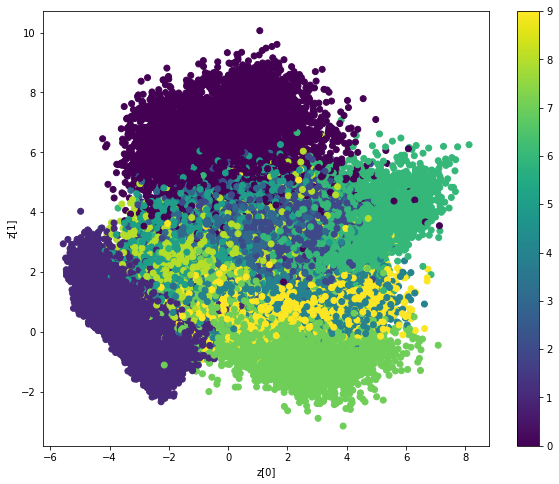

In [52]:
def plot_clusters( data, labels):
    # visualising the latent space
    mean, _, _ = vae.encoder.predict(data)
    plt.figure(figsize=(10, 8))
    
    mean_dim1 = mean[:,0]
    mean_dim2 = mean[:,1]
    plt.scatter(mean_dim1, mean_dim2, c=labels, linewidths = 1, edgecolors = None)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()

# print(x_train.shape)

plot_clusters(x_train, y_train)

(9, 28, 28, 1)
Real Images


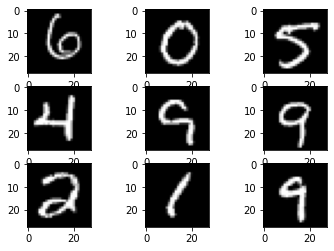

Reconstructed Images with VAE


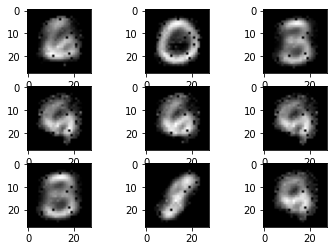

In [61]:

offset=100
num = 9 #num should be less than 10
data = x_test[offset: num+offset,:]
output = vae.predict(data)*255
print(output.shape)

print ("Real Images")
for i in range(num):
    plt.subplot(330 + 1 + i)
    plt.imshow(data[i], cmap='gray')
plt.show()

print ("Reconstructed Images with VAE")
for i in range(num):
    plt.subplot(330 + 1 + i)
    plt.imshow(output[i], cmap='gray')
plt.show()